<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/ctf_aliasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
* investigate rapidly oscilating CTF, and aliasing effects

# Resources
* Penczek, P. A., & et al. (2014). CTER—Rapid estimation of CTF parameters with error assessment. Ultramicroscopy. http://doi.org/10.1016/j.ultramic.2014.01.009

* https://github.com/cryoem/eman2/blob/master/sparx/libpy/morphology.py

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [273]:
voltage = 300 # in kev
lam = 12.398/np.sqrt(voltage*(1022.0+voltage))  #  All units in A
Cs = 2
defocus = 1
pix=.5 # in A
nx=512
n = nx//2+1
fwpix = 1./(2*pix)
fcycle = 1./(2*fwpix)
fper = 1.0/fcycle

cis = Cs*1.e7 # mm
A = 0.5*defocus*10000.0*lam # defocus in um
B = 0.25*cis*lam*lam*lam

In [266]:
def ctf_1d(defocus, Cs, lam, nx,pix):
  freq = np.arange(start=0,stop=1/(2*pix),step=1/(nx*pix))
  cis = Cs*1.e7 # mm
  A = 0.5*defocus*10000.0*lam # defocus in um
  B = 0.25*cis*lam*lam*lam
  f2 = freq*freq
  gamma = 2*np.pi*(-A*f2+B*f2*f2)
  return(np.sin(gamma), freq)



The CTF is the same, but goes out more to higher resolution when we adjust the number of pixels and the pixel size by $(n_x,p) \rightarrow (n_xf,p/f)$

(256,)

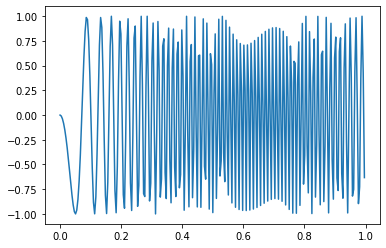

In [274]:
ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx,pix=pix)
sr = pd.Series(ctf)
sr.index = freq
sr.plot()
ctf.shape

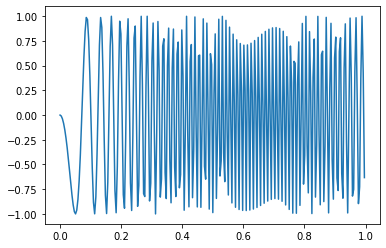

In [275]:
factor=2
ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx*factor,pix=pix/factor)
sr = pd.Series(ctf[:nx//2]) # but goes out double this
sr.index = freq[:nx//2]
sr.plot()

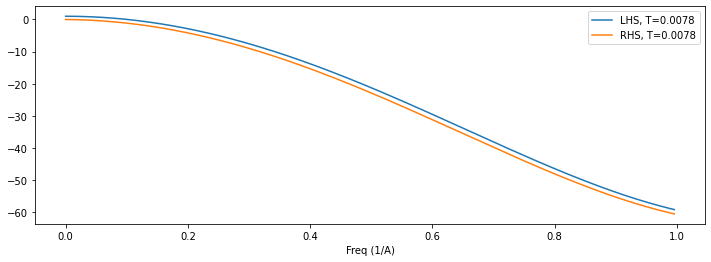

In [276]:
ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx,pix=pix)
f2 = freq*freq

T = 2/(nx*pix)
fT2 = (freq+T)**2
LHS = (-A*f2+B*f2*f2) + 1
RHS = (-A*fT2+B*fT2*fT2)

fig,axes = plt.subplots(nrows=1,figsize=(12,4))

sr = pd.Series(LHS)
sr.index = freq
sr.plot(ax=axes,label='LHS, T=%.4f'%T,legend=True)
axes.set_xlabel('Freq (1/A)')

sr = pd.Series(RHS)
sr.index = freq
sr.plot(ax=axes,label='RHS, T=%.4f'%T,legend=True)

# Scratch

In [128]:
def ctfperiod(defocus, Cs, lam, freq):
  # find local "period" T by solving fourth order polynomial resulting from equation:
  #  sin( 2pi (gamma(freq) + 1) ) = sin( 2pi (gamma(freq+T) )
  cis = Cs*1.e7 # mm
  A = 0.5*defocus*10000.0*lam # defocus in um
  B = 0.25*cis*lam*lam*lam
  f2 = freq*freq
  """
  for i in xrange(800):
    ff = freq+(i-400)*0.00002
    print  ff,Util.tf(defocus, ff, voltage, Cs, 10., 0.0, 1.0)
  """
  rot = np.roots([B, 4*B*freq, 6*B*f2-A, 4*B*f2*freq-2*A*freq, -1.0])
  #print np.roots([A,2*A*freq,1.0]),-freq-np.sqrt(f2/2-1./A),-freq+np.sqrt(f2-1./A)
  #print  Util.tf(defocus, freq, voltage, Cs, 10., 0.0, 1.0),Util.tf(defocus, freq+min(rot), voltage, Cs, 10., 0.0, 1.0)
  return rot # min(abs(rot))

In [ ]:
# cis = Cs*1.e7 # mm
# A = 0.5*defocus*10000.0*lam # defocus in um
# B = 0.25*cis*lam*lam*lam
# f2 = freq*freq

# Ts = np.linspace(0.05,0.15,10)
# fig,axes = plt.subplots(nrows=len(Ts),figsize=(12,24))
# for idx,T in enumerate(Ts):
#   ctf,freq = ctf_1d(defocus, Cs, lam, nx=nx,pix=1)
#   f2 = freq*freq
#   fT2 = (freq+T)**2
#   LHS = (-A*f2+B*f2*f2) + 1
#   RHS = (-A*fT2+B*fT2*fT2)
#   sr = pd.Series(LHS)
#   sr.index = freq
#   sr.plot(ax=axes[idx],label='LHS, T=%.2f'%T,legend=True)
#   axes[idx].set_xlabel('Freq (1/A)')

#   sr = pd.Series(RHS)
#   sr.index = freq
#   sr.plot(ax=axes[idx],label='RHS, T=%.2f'%T,legend=True)


In [196]:
freq.shape, nx

((256,), 512)

In [ ]:
for ii in range(n-1,1,-1): # from n-1 up to and including 2, decreasing by 1
  xr = ii/float(n-1)/(2*pix) # decreasing, frac/(2*pix), where frac is [1,n-2/(n-1),..,2/(n-1)]
  ctfper = ctfperiod(defocus, cs, lam, xr)
  print('ctfper',ctfper)
  if(ctfper >  fper):
    print (" Limiting frequency is:",xr,"  limiting resolution is:",1.0/xr)